<a href="https://colab.research.google.com/github/MCRLdata-Sandbox/tutorials/blob/main/ML_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Welcome!

This tutorial is designed to provide an introduction to machine learning (ML) for users with any level of experience with coding. All code is written in R, but you do NOT need to know or learn R to complete this tutorial!

ML is a subset of artificial intelligence (AI) where the computer can learn and improve its performance of a task without the user's input. It can be very useful for a wide variety of data-based tasks, and there are many different algorithms that perform many different types of tasks.

For this tutorial we will focus on one ML algorithm: Random Forests (RF). RF is a very useful algorithm we can use to predict relationships between different variables. RF is relativel robust to many of the factors that can cause problems in normal statistical models (things like co-correlation of predictors, non-normal distributions, and non-linear relationships).



## 2. Setup

Before we start anything, we need to set up our coding environment. Because getting a coding language like R or Python running on your computer is often an involved process, this tutorial takes advantage of Google Colab, which pre-loads all of the software you need. You do, however, need to install packages and set up your environment. We'll do this by running the code chunk below (press the play button in the upper-left).

**IMPORTANT: from here on, when you see a code chunk with a play button, you can press play! Please do not skip code chunks as the code below generally depends on the code above**

This code chunk will take a couple minutes (<5 minutes on my machine) because R needs to install and load several libraries. All other code chunks will run much faster!


In [ ]:
## I want to understand how long things take
install.packages('tictoc')
library(tictoc)

## Install and load required packages
tic("install and load packages")
install.packages(c('tidyverse', 'rsample', 'fuzzyjoin', 'cowplot', 'ranger'))

library(tidyverse) # keeps our data flows tidy
library(rsample) # used for splitting data into train and test subsets
library(fuzzyjoin) # used to give leniency when joining data by timestamp
library(cowplot) # make multi-facet plots
library(ranger) # Random Forest algorithm
toc()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘warp’, ‘sp’, ‘furrr’, ‘slider’, ‘stringdist’, ‘geosphere’, ‘RcppEigen’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




install and load packages: 310.698 sec elapsed


While that's loading, let's start with the question we want our model to answer - **Can we use basic hydrology and water quality data to predict aquatic carbon dioxide concentrations in Sequim Bay?**

This is a  common type of question to ask ML to solve and while it seems simple, finding the answer can be a complicated process. This tutorial leverages the awesome datasets being collected off the MCRL dock by the [MCRLdata](https://mcrldata.pnnl.gov/) pipeline. We will use the partial pressure of carbon dioxide in water (pCO2) as the variable we want to predict, and a range of parameters, including water temperature, tidal stage, windspeed, and others as our predictors.

Since this tutorial is focused on a practical application of ML and not on R coding, I will not explain code chunks in detail. If you are interested in a starting point for learning R, I suggest checking out these [tutorials](https://github.com/MCRLdata-Sandbox/tutorials), starting with [0_R_basics](https://github.com/MCRLdata-Sandbox/tutorials/blob/main/scripts/0_R_basics.R)

## 3. Import and check data

Now that we have all the packages loaded that we need, let's read in our datasets. These datasets live in the [MCRLdata Sandbox](https://github.com/MCRLdata-Sandbox)[<https://github.com/MCRLdata-Sandbox/data_prep/tree/main/data/outputs/L1>] and have basic quality control applied. We are going to use predictors from four datasets: 1. pCO2 - partial pressure of CO2 2. tide - tidal stage 3. ctd - water temperature 4. wind - windspeed:

In [ ]:

## Read in data from https://github.com/MCRLdata-Sandbox/data_prep/tree/main/data/outputs/L1

pco2 <- read_csv("https://raw.githubusercontent.com/MCRLdata-Sandbox/data_prep/refs/heads/main/data/outputs/L1/250815_pco2_L1.csv")
tide <- read_csv("https://raw.githubusercontent.com/MCRLdata-Sandbox/data_prep/refs/heads/main/data/outputs/L1/250515_tidegauge_L1.csv")
ctd <- read_csv("https://raw.githubusercontent.com/MCRLdata-Sandbox/data_prep/refs/heads/main/data/outputs/L1/250815_ctd_water_temp_salinity_L1.csv")
wind <- read_csv("https://raw.githubusercontent.com/MCRLdata-Sandbox/data_prep/refs/heads/main/data/outputs/L1/250630_windspeed_L1.csv")

Rows: 4066 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (4): qc_pco2_water, qc_pco2_air, p_co2_in_water_ppm, p_co2_in_air_ppm
dttm (1): time_pst

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 375940 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): tide, tide2
dbl  (1): water_level_m_navd88
dttm (1): time_pst

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 249028 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): temp_deg_c, salinity_psu_clean
dttm (1): time_pst

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set

### Check gaps

Random forests can be sensitive to missing values that create gaps in our time-series data. If any value is missing for any dependent or independent variable, that row will not be included in the model. Let's do a gap analysis to understand what gaps we have in our dataset. First, we look through our dataset to see if there are any irregular time-stamps:

In [ ]:
## For plots, let's set a theme
theme_set(theme_bw())

## First, we check if all our time-stamps are consistently at 3-hour intervals
## We see some are not, which we will fix below
pco2 %>%
  mutate(time_round = round_date(time_pst, "3 hours")) %>%
  filter(time_round != time_pst)

time_pst,qc_pco2_water,qc_pco2_air,p_co2_in_water_ppm,p_co2_in_air_ppm,time_round
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>
2023-10-21 08:00:00,0,0,952.6552,471.1204,2023-10-21 09:00:00
2023-10-21 08:30:00,0,0,964.0845,454.5521,2023-10-21 09:00:00
2023-10-21 09:30:00,0,0,966.1938,428.1491,2023-10-21 09:00:00
2023-10-21 10:00:00,0,0,976.3962,437.4560,2023-10-21 09:00:00
2023-10-21 10:30:00,0,0,955.4208,438.1012,2023-10-21 12:00:00


We'll fix those values so that there is only one pCO2 value per 3-hour interval. Next, we will plot our pCO2 data and mark all gaps larger than 3 hours (the temporal resolution of our pCO2 dataset) with red dots:

In [ ]:
## We can bin these values to create a homogenous time-series
pco2_gaps <- pco2 %>%
  mutate(time_pst = round_date(time_pst, "3 hours")) %>%  # standardize datetimes
  group_by(time_pst) %>%
  summarize(p_co2_in_water_ppm = mean(p_co2_in_water_ppm, na.rm = T)) %>%
  drop_na(p_co2_in_water_ppm) %>%
  mutate(delta_time = as.numeric(minutes(time_pst - lag(time_pst))))

ggplot(pco2_gaps, aes(time_pst, p_co2_in_water_ppm)) +
    geom_line(color = "gray") +
    geom_point(data = pco2_gaps %>% filter(delta_time > 3*60), alpha = 0.5, color = "red")

### Select dataset for model

While we will not be gap-filling (which can be a big can of worms) in this tutorial, gaps can become problems for different data analyses, including ML approaches, so it is good to be aware of them. For the sake of keeping things simple, we will focus periods of pCO2 data with minimal or no gaps for this tutorial.

Let's pick an example time-period for constructing our first model:

In [ ]:
df_all <- left_join(pco2_gaps %>%
                        dplyr::select(time_pst, p_co2_in_water_ppm),
                tide %>% dplyr::select(time_pst, water_level_m_navd88),
                by = "time_pst") %>%
  left_join(., ctd %>% dplyr::select(time_pst, temp_deg_c),
                by = "time_pst") %>%
  left_join(., wind %>% dplyr::select(time_pst, windspeed_avg_m_s),
                by = "time_pst") %>%
  unique()

plot_gaps <- function(data, var, ylab){

  gap_threshold = 60*3 #60min/hr * 3 hrs (pCO2 resolution)

  x <- data %>%
    mutate(delta_time = as.numeric(minutes(time_pst - lag(time_pst))))

  ## This is a nice chunk of data!
  start1 = as_datetime("2023-08-15")
  end1 = as_datetime("2023-12-01")

  ggplot(x, aes(time_pst, {{var}})) +
    geom_line(color = "gray") +
    geom_point(data = x %>% filter(delta_time > gap_threshold), alpha = 0.5, color = "red") +
    annotate(geom = "rect", xmin = start1, xmax = end1,
             ymin = -Inf, ymax = Inf,
             fill = "blue", alpha = 0.1) +
    ylab(ylab) +
    scale_x_datetime(limits = c(as_datetime("2023-07-01"),
                                as_datetime("2025-06-01")))
}

plot_grid(plot_gaps(df_all, p_co2_in_water_ppm, "pCO2 (ppm)"),
          plot_gaps(df_all, water_level_m_navd88, "WL \n (m NAVD88)"),
          plot_gaps(df_all, temp_deg_c, "Temp (C)"),
          plot_gaps(df_all, windspeed_avg_m_s, "Windspeed \n (m/s)"),
          ncol = 1, align = "hv")

df1 <- df_all %>%
  filter(time_pst > as_datetime("2023-08-15") &
           time_pst < as_datetime("2023-12-01")) %>%
  mutate(doy = yday(time_pst),
         month = month(time_pst),
         hour = hour(time_pst)) %>%
  mutate(white_noise = rnorm(1:n(), mean = 0, sd = 1))

ERROR: Error in left_join(pco2_gaps %>% dplyr::select(time_pst, p_co2_in_water_ppm), : could not find function "%>%"


## 4. Our first Random Forest Model

Now that we have looked at our data and selected an appropriate time-period, we are ready to make our first model! There are many steps to making a **good and trustworthy model**, but let's start at the very beginning and make the simplest model we can, then build from there. Our question is about predicting pCO2 from other environmental variables, which we have included in our datasets. That means pCO2 is our dependent variable (the variable we want to predict / understand), and water temperature, tidal stage, and windspeed are all independent variables (the variables we are using to predict).

In [ ]:
rf0 <- ranger(p_co2_in_water_ppm~water_level_m_navd88+temp_deg_c+windspeed_avg_m_s, data = df1)
rf0

Ranger result

Call:
 ranger(p_co2_in_water_ppm ~ water_level_m_navd88 + temp_deg_c +      windspeed_avg_m_s, data = df1) 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      846 
Number of independent variables:  3 
Mtry:                             1 
Target node size:                 5 
Variable importance mode:         none 
Splitrule:                        variance 
OOB prediction error (MSE):       9663.376 
R squared (OOB):                  0.7853834 

This model looks great! We get an R2 of 0.79 which is pretty high (your R2 may be slighly different - the model uses randomness so the R2 will change some, but not a lot, between runs). So we're done right?

**WRONG.**

There are a couple important things we need to note here. First, we have given the model all of our data. That means the model is not honestly predicting values, but instead of learning about the patterns and relationships in the dataset and then doing a reasonably good job of reproducing them.

Let's see what happens when we split our dataset, so the model trains on data we allow it see, but then we test the model on data it has never seen before:

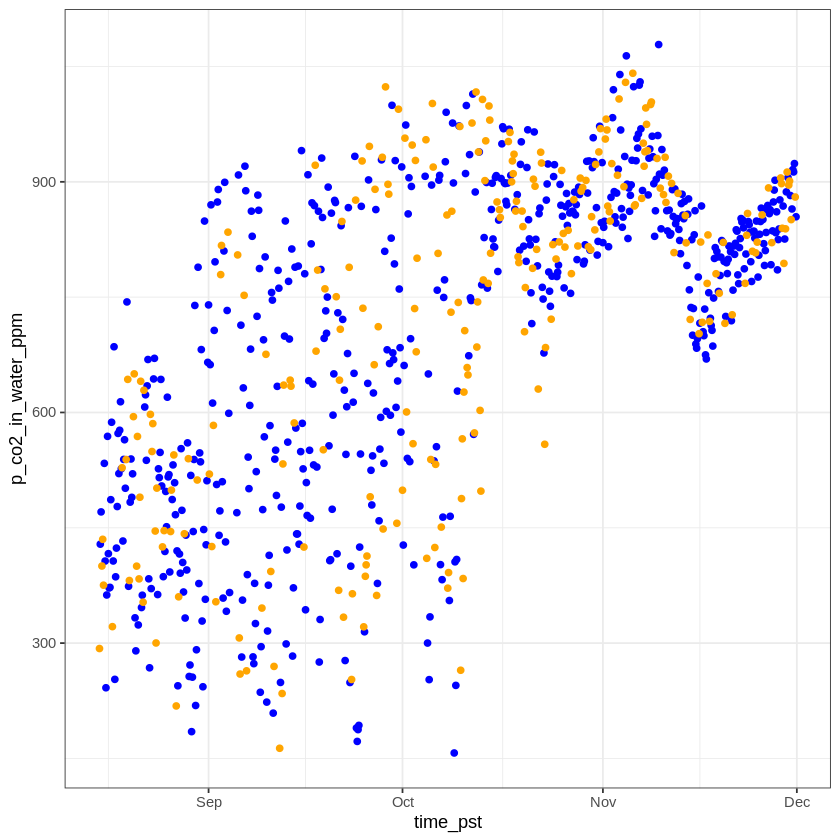

In [ ]:
## Let's split the data into 70% training / 30% testing
  set.seed(42)
  split_data <- initial_split(df1, prop = 0.7)
  train = training(split_data)
  test = testing(split_data)

ggplot(df1, aes(time_pst, p_co2_in_water_ppm)) +
  geom_point(data = train, color = "blue") +
  geom_point(data = test, color = "orange")

In the plot above, the blue points are our training dataset, and the orange points are our testing dataset. We will construct our next model based only on the blue points, and then we will test how well our model understands our dataset by making it predict the orange points:

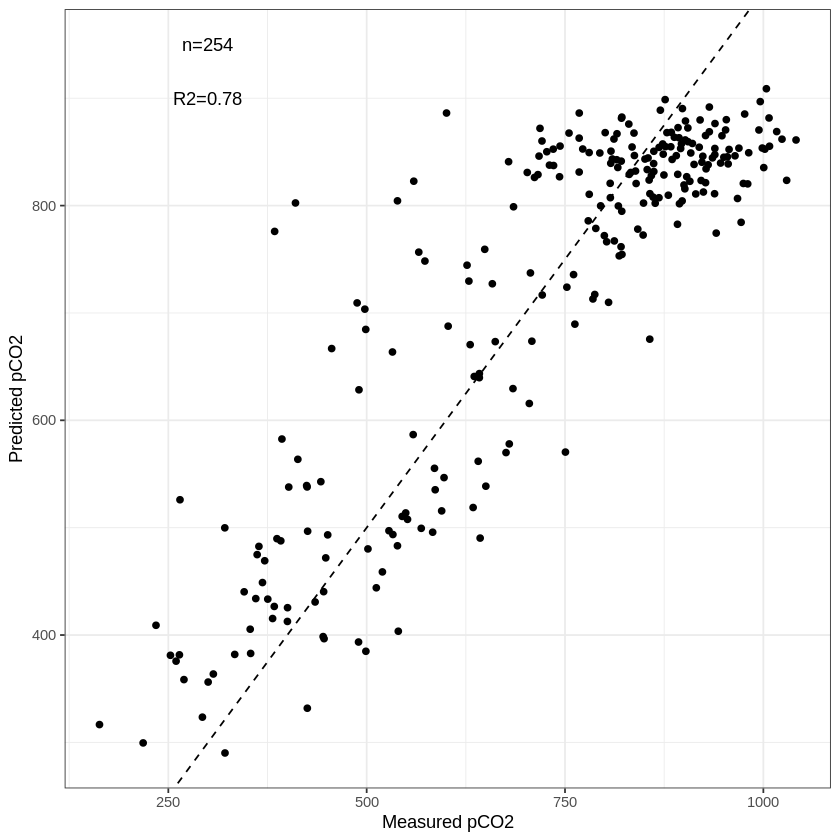

In [ ]:
rf1 <- ranger(p_co2_in_water_ppm~water_level_m_navd88+temp_deg_c+windspeed_avg_m_s, data = train)

test$predicted <- predict(rf1, test)$predictions

r2 <- summary(lm(predicted~p_co2_in_water_ppm, data = test))[[9]]

ggplot(test, aes(p_co2_in_water_ppm, predicted)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  annotate(geom = "text", x = 300, y = 900, label = paste0("R2=", round(r2, 2))) +
  annotate(geom = "text", x = 300, y = 950, label = paste0("n=",nrow(test))) +
  labs(x = "Measured pCO2", y = "Predicted pCO2")

Our R2 has not really changed, which is wonderful news! Our model is still doing relatively well at predicting pCO2 values it hasn't seen (testing dataset) from the relationships it has developed between pCO2 and our independent variables (water level, water temp, and windspeed) for data it has seen (training dataset). Looking at this plot, we can not only see the goodness-of-fit (R2), but also other information about model performance, like where the model is under-estimating values (highest measured pCO2).

The purpose of this tutorial is not to dig into the details of constructing a robust, predictive model. With that being said, there are numerous resources available online for walking through all of the steps to make the best possible model. One tutorial that I highly recommend if you want to explore RF models with R further is https://www.youtube.com/watch?v=ts5bRZ7pRKQ.

## 5. Interpreting our model

Let's take a step back to our original split model. As a reminder, it looks like this:

In [ ]:
set.seed(42)
  split_data <- initial_split(df1, prop = 0.7)
  train = training(split_data)
  test = testing(split_data)

rf1_p1 <- ggplot(data = df1,
       aes(time_pst, p_co2_in_water_ppm)) +
  geom_point(data = train, color = "blue") +
  geom_point(data = test, color = "orange") +
  labs(x = "Date", y = "Measured pCO2")

rf1 <- ranger(p_co2_in_water_ppm~water_level_m_navd88+temp_deg_c+windspeed_avg_m_s,
              data = train, importance = "impurity")

test$predicted <- predict(rf1, test)$predictions

r2 <- summary(lm(predicted~p_co2_in_water_ppm, data = test))[[9]]

rf1_p2 <- ggplot(test, aes(p_co2_in_water_ppm, predicted)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  annotate(geom = "text", x = 300, y = 900, label = paste0("R2=", round(r2, 2))) +
  annotate(geom = "text", x = 300, y = 950, label = paste0("n=",nrow(test))) +
  labs(x = "Measured pCO2", y = "Predicted pCO2")

plot_grid(rf1_p1, rf1_p2, nrow = 1)

### 5.1 Feature Importance

Aside from how well the model performs, we also want to understand how the inputs contribute to the model. This is call feature importance, where "features" are our independent variables. This information is calculated by the ranger() function, and my favorite way to visualize this is as a bar chart, where the y-axis is each of our features, and the x-axis is the % of the predictive power of the model each feature contributes:

In [ ]:
plot_fi <- function(model){

  var_names <- model$variable.importance
  col_names <- c("predictor", "raw_fi")

  ## Convert feature importance to a tibble with variables as a column
fi1 <- as.data.frame(var_names) %>%
  tibble::rownames_to_column() %>%
  as_tibble()

## Rename columns
colnames(fi1) = col_names

## This plot gives us the percentage of the Random Forest's predictive power
## contributed by each variable.
fi1 %>%
  mutate(fi = raw_fi / sum(raw_fi)) %>%
  ggplot(aes(fi * 100,
               reorder(predictor, fi), fill = predictor)) +
  geom_col(alpha = 0.8, show.legend = F, width = 0.7) +
  labs(x = "Feature Importance (%)",
       y = "", fill = "") +
  scale_fill_viridis_d()
}

plot_fi(rf1)

We can see that temperature contributes the majority of predicitive power to our model (~80%) while water level and windspeed contribute less than 10%. This brings up a question: do we even need water level and windspeed? One quantitative way to assess this, is to add white noise into our model as a predictor. If any independent variable has a lower feature importance than white noise, we can confidently remove it as a non-important predictor. Let's rerun our model and add in white noise. For fun, let's add in month, day of year (doy) and the hour of day (hour):


In [ ]:
set.seed(42)

rf4 <- ranger(p_co2_in_water_ppm~water_level_m_navd88+temp_deg_c+windspeed_avg_m_s+hour+doy+month+white_noise, data = train, importance = "impurity")

plot_rf_fit <- function(model, test_data){

  test_data$predicted <- predict(model, test_data)$predictions

r2 <- summary(lm(predicted~p_co2_in_water_ppm, data = test))[[9]]

ggplot(test_data, aes(p_co2_in_water_ppm, predicted)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  annotate(geom = "text", x = 400, y = 900, label = paste0("R2=", round(r2, 2))) +
  annotate(geom = "text", x = 400, y = 950, label = paste0("n=",nrow(test_data))) +
  labs(x = "Measured pCO2", y = "Predicted pCO2")
}

plot_grid(plot_rf_fit(rf4, test), plot_fi(rf4), nrow = 1)

We can see that the most important feature to our model's predictive power is still temperature, but now day of year (doy)
 and month are the second- and third-most important features. Also, we see that white noise is more important than windspeed. This tells us that windspeed is contributing less to the model than randomness, meaning it is not an important predictor. Moving forward, we will leave windspeed out of our analysis, since including a variable that does not contribute meaningfully to the model means some trees in our random forest are being given information on windspeed (which doesn't help it predict pCO2 well) instead of information from other variables like temperature or doy that would likely predict pCO2 better.

  
### 5.2 Partial dependence

In addition to understanding the importance of each feature, we can explore the relationships between each feature and the dependent variable using partial dependency plots. These are similar to the relationship between pCO2 and the variable, but (importantly) show us how the model represents those relationships. Let's plot relationships for the top 4 independent variables based on feature importance:

In [ ]:
calculate_pdp <- function(var){
  pdp::partial(rf4, pred.var = var, train = train) %>%
  rename("pco2_ppm" = yhat) %>%
    ggplot(aes(pco2_ppm, .data[[var]])) +
    geom_point(alpha = 0.2, size = 1) +
    geom_line(alpha = 0.2) +
    geom_smooth(se = F)
}

plot_grid(calculate_pdp("temp_deg_c"),
          calculate_pdp("doy"),
          calculate_pdp("month"),
          calculate_pdp("water_level_m_navd88"), ncol = 2)

These plots tell us some additional interesting information about our model. For instance, temperature provides a pretty consistent relationship to pCO2, with lower pCO2 at higher temperatures and higher pCO2 at lower temperatures (consistent with solubility, for instance). We see large changes in water level relate to changes in pCO2, with low tide occuring around 700-710 ppm. While this information by itself is not particularly useful, it can be helpful in identifying threshold behavior in our dataset. We should also keep in mind when looking at these plots that we are only using a couple of months of data. If you were to use a full year-long time-series, these plots (especially doy and month) would look different.

## 6. Tuning your model

Now that we have some of the basics for Random Forests down, it's time to play around with tuning our model! Tuning means changing the parameters that control how the model is built. As a quick reminder, here is the model we are currently using:

In [ ]:
ranger(p_co2_in_water_ppm~water_level_m_navd88+temp_deg_c+month+hour+doy,
              data = train, importance = "impurity")

The output of the ranger function does not tell us our split ratio - we set that when we split our dataset into train and test. It does tell us the model is using 500 trees, and each tree is given two variables (mtry). Let's explore how each of these factors influences how well our model performs! We'll run the model many times for each combination of the following values:

 - Split ratio: 50/50, 60/40, 70/30, 80/20, 90/10
 - Number of trees: 50, 200, 500, 1000, 2000
 - mtry: 1, 2, 3, 4, 5

In [ ]:
## Set our ranges
split_ratio = c(0.5, 0.7, 0.9)
ntree = c(50, 500, 1000)
mtry = c(1:5)

## Make a dataframe with rows for every combination of parameters
model_parameters <- expand_grid(split_ratio = split_ratio,
            ntree = ntree,
            mtry = mtry)

make_model <- function(i){

  ## Pull the parameters to use for the model and rename them
  parameters <- model_parameters %>% slice(i)
  split_ratio = parameters$split_ratio
  ntree = parameters$ntree
  mtry = parameters$mtry

  ## Split data based on split_ratio
  split_data <- initial_split(df1, prop = split_ratio)
  train = training(split_data)
  test = testing(split_data)

  ## Make model based on ntree and mtry
  model <- ranger(p_co2_in_water_ppm~water_level_m_navd88+temp_deg_c+month+hour+doy,
               ntree = ntree, mtry = mtry,
              data = train, importance = "impurity")

  test$predicted <- predict(model, test)$predictions

  r2 <- summary(lm(predicted~p_co2_in_water_ppm, data = test))[[9]]

  tibble(split_ratio = split_ratio,
         ntree = ntree,
         mtry = mtry,
         r2 = round(r2, 2))
}


parameter_results <- 1:nrow(model_parameters) %>%
  map(make_model) %>%
  bind_rows()

plot_parameter_results <- function(parameter, xlab){
  ggplot(parameter_results, aes(as.factor({{parameter}}), r2,
                                fill = as.factor({{parameter}}))) +
    geom_point(alpha = 0.5, show.legend = F) +
  geom_violin(alpha = 0.5, show.legend = F) +
    scale_color_viridis_d() +
    scale_fill_viridis_d() +
    labs(x = xlab, y = "Model R2")
}

plot_grid(plot_parameter_results(split_ratio, "Split Ratio"),
          plot_parameter_results(ntree, "# of Trees"),
          plot_parameter_results(mtry, "mtry"),
          nrow = 1)